**Load Libaries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

**Utility Functions**

In [11]:
def one_hot(y, num_classes):
    Y = np.zeros((y.shape[0], num_classes))
    Y[np.arange(y.shape[0]), y] = 1
    return Y

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

**Neural Network Class**

In [12]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, seed=42):
        np.random.seed(seed)
        h1, h2, h3 = hidden_dims

        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, output_dim))

    def forward(self, X):
        z1 = X.dot(self.W1) + self.b1
        a1 = relu(z1)

        z2 = a1.dot(self.W2) + self.b2
        a2 = relu(z2)

        z3 = a2.dot(self.W3) + self.b3
        a3 = relu(z3)

        logits = a3.dot(self.W4) + self.b4

        cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2,
                 'z3': z3, 'a3': a3, 'logits': logits}
        return logits, cache

    def compute_loss_and_probs(self, logits, Y_true):
        probs = softmax(logits)
        eps = 1e-12
        probs_clipped = np.clip(probs, eps, 1.0 - eps)
        N = Y_true.shape[0]
        loss = -np.sum(Y_true * np.log(probs_clipped)) / N
        return loss, probs

    def backward(self, probs, cache, Y_true):
        N = Y_true.shape[0]
        X = cache['X']
        a1 = cache['a1']
        a2 = cache['a2']
        a3 = cache['a3']

        dlogits = (probs - Y_true) / N
        dW4 = a3.T.dot(dlogits)
        db4 = np.sum(dlogits, axis=0, keepdims=True)

        da3 = dlogits.dot(self.W4.T)
        dz3 = da3 * drelu(cache['z3'])
        dW3 = a2.T.dot(dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)

        da2 = dz3.dot(self.W3.T)
        dz2 = da2 * drelu(cache['z2'])
        dW2 = a1.T.dot(dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2.dot(self.W2.T)
        dz1 = da1 * drelu(cache['z1'])
        dW1 = X.T.dot(dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = {'dW4': dW4, 'db4': db4,
                 'dW3': dW3, 'db3': db3,
                 'dW2': dW2, 'db2': db2,
                 'dW1': dW1, 'db1': db1}
        return grads

    def update_params(self, grads, lr=0.01):
        self.W4 -= lr * grads['dW4']
        self.b4 -= lr * grads['db4']

        self.W3 -= lr * grads['dW3']
        self.b3 -= lr * grads['db3']

        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']

        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']

    def predict(self, X):
        logits, _ = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

**Generate synthetic dataset**

In [13]:
def generate_dataset(n_samples=2000, n_features=20, n_classes=5, random_state=42):
    X, y = make_classification(n_samples=n_samples,
                               n_features=n_features,
                               n_informative=int(n_features * 0.6),
                               n_redundant=int(n_features * 0.1),
                               n_clusters_per_class=1,
                               n_classes=n_classes,
                               random_state=random_state)
    return X, y

**Train Model**

In [5]:
def train_network(model, X_train, Y_train, X_val, Y_val,
                  epochs=100, batch_size=64, lr=0.01, verbose=True):
    n = X_train.shape[0]
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    for ep in range(1, epochs + 1):
        perm = np.random.permutation(n)
        X_shuf = X_train[perm]
        Y_shuf = Y_train[perm]

        epoch_loss = 0.0
        correct = 0
        steps = 0

        for i in range(0, n, batch_size):
            X_batch = X_shuf[i:i + batch_size]
            Y_batch = Y_shuf[i:i + batch_size]

            logits, cache = model.forward(X_batch)
            loss, probs = model.compute_loss_and_probs(logits, Y_batch)
            grads = model.backward(probs, cache, Y_batch)
            model.update_params(grads, lr=lr)

            epoch_loss += loss * X_batch.shape[0]
            preds = np.argmax(probs, axis=1)
            correct += np.sum(preds == np.argmax(Y_batch, axis=1))
            steps += 1

        avg_loss = epoch_loss / n
        train_acc = correct / n

        logits_val, _ = model.forward(X_val)
        val_loss, val_probs = model.compute_loss_and_probs(logits_val, Y_val)
        val_preds = np.argmax(val_probs, axis=1)
        val_acc = np.mean(val_preds == np.argmax(Y_val, axis=1))

        history['loss'].append(avg_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if verbose and (ep % max(1, epochs // 10) == 0 or ep == 1):
            print(f"Epoch {ep:3d}/{epochs} - loss: {avg_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    return history

**Run Everything**

In [14]:
if __name__ == "__main__":
    n_samples = 2000
    n_features = 30
    n_classes = 5
    hidden_dims = [64, 32, 16]
    epochs = 80
    batch_size = 64
    lr = 0.05
    test_size = 0.2
    random_state = 42

    X, y = generate_dataset(n_samples=n_samples, n_features=n_features,
                            n_classes=n_classes, random_state=random_state)

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.1, random_state=random_state, stratify=y_train_full)

    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0) + 1e-12
    X_train = (X_train - mu) / sigma
    X_val = (X_val - mu) / sigma
    X_test = (X_test - mu) / sigma

    Y_train = one_hot(y_train, n_classes)
    Y_val = one_hot(y_val, n_classes)
    Y_test = one_hot(y_test, n_classes)

    model = NeuralNetwork(input_dim=n_features, hidden_dims=hidden_dims, output_dim=n_classes)

    history = train_network(model, X_train, Y_train, X_val, Y_val,
                            epochs=epochs, batch_size=batch_size, lr=lr, verbose=True)

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print("\nTest Accuracy: {:.4f}".format(test_acc))
    print("\nClassification Report (per class):\n")
    print(classification_report(y_test, y_pred, digits=4))

Epoch   1/80 - loss: 1.5704 - acc: 0.2944 - val_loss: 1.5273 - val_acc: 0.3375
Epoch   8/80 - loss: 0.6523 - acc: 0.7611 - val_loss: 0.7448 - val_acc: 0.7375
Epoch  16/80 - loss: 0.3772 - acc: 0.8729 - val_loss: 0.5720 - val_acc: 0.8000
Epoch  24/80 - loss: 0.2251 - acc: 0.9403 - val_loss: 0.5136 - val_acc: 0.8438
Epoch  32/80 - loss: 0.1383 - acc: 0.9667 - val_loss: 0.4703 - val_acc: 0.8562
Epoch  40/80 - loss: 0.0845 - acc: 0.9868 - val_loss: 0.4692 - val_acc: 0.8562
Epoch  48/80 - loss: 0.0541 - acc: 0.9951 - val_loss: 0.4558 - val_acc: 0.8688
Epoch  56/80 - loss: 0.0370 - acc: 0.9958 - val_loss: 0.4638 - val_acc: 0.8688
Epoch  64/80 - loss: 0.0259 - acc: 0.9979 - val_loss: 0.4768 - val_acc: 0.8625
Epoch  72/80 - loss: 0.0194 - acc: 0.9993 - val_loss: 0.4797 - val_acc: 0.8625
Epoch  80/80 - loss: 0.0152 - acc: 0.9993 - val_loss: 0.4995 - val_acc: 0.8812

Test Accuracy: 0.8500

Classification Report (per class):

              precision    recall  f1-score   support

           0    

**Plot Everything**

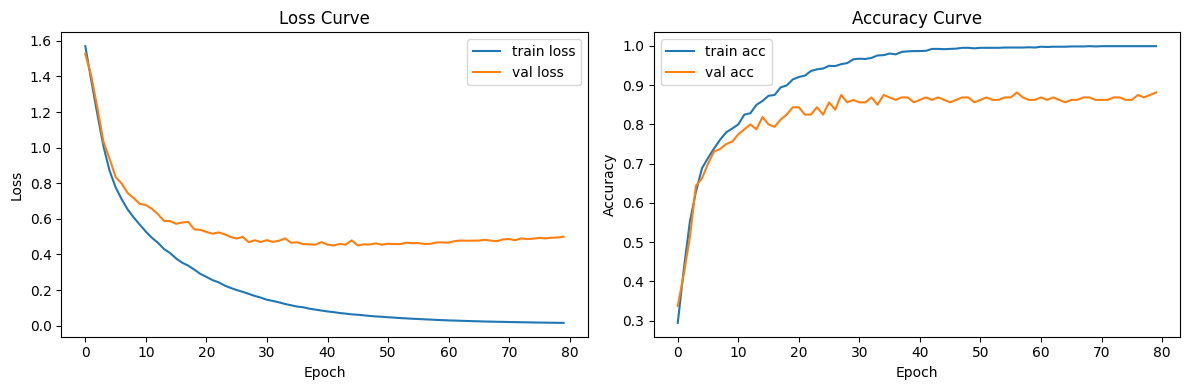

Confusion matrix, without normalization


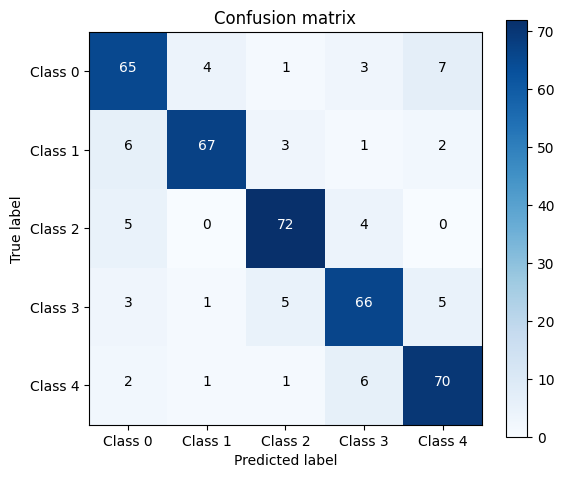

Normalized confusion matrix


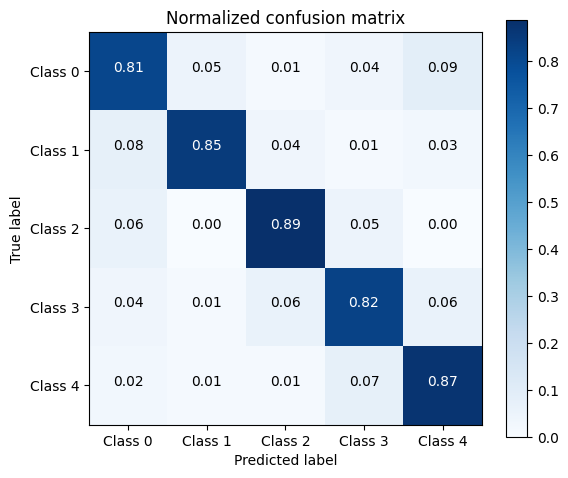

In [15]:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(history['acc'], label='train acc')
    plt.plot(history['val_acc'], label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.tight_layout()
    plt.show()

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")

        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                txt = f"{cm[i, j]:.2f}"
            else:
                txt = f"{cm[i, j]:d}"
            plt.text(j, i, txt,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

    class_names = [f"Class {i}" for i in range(n_classes)]
    plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion matrix')
    plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')